<a href="https://colab.research.google.com/github/fayrouz2/ai-pros-v1-2025/blob/main/horse_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Build a Dataset Class for Horse Breeds**

https://www.kaggle.com/datasets/olgabelitskaya/horse-breeds

##### Imports

In [1]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import zipfile
import random
import copy
import time
from sklearn.metrics import f1_score,accuracy_score
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, WeightedRandomSampler
import requests
from io import BytesIO

In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, Subset, random_split, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
import torch.nn as nn
import torch.optim as optim
import numpy as np


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("olgabelitskaya/horse-breeds")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'horse-breeds' dataset.
Path to dataset files: /kaggle/input/horse-breeds


##### helper functions for visualization

In [4]:
def imshow(inp, title=None, ax=None):
    """
    Display image for Tensor.
    
    Args:
        inp: Tensor image of shape (C, H, W) or (H, W, C)
        title: Optional title for the image
        ax: Optional matplotlib axis to plot on
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    # Convert tensor to numpy if needed
    if isinstance(inp, torch.Tensor):
        inp = inp.numpy()
    
    # Handle different input shapes
    if inp.shape[0] == 3 or inp.shape[0] == 1:  # (C, H, W)
        inp = inp.transpose((1, 2, 0))
    
    # Denormalize if needed (assuming ImageNet normalization)
    if inp.min() < 0 or inp.max() > 1:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
    
    # Handle grayscale images
    if len(inp.shape) == 2 or (len(inp.shape) == 3 and inp.shape[2] == 1):
        ax.imshow(inp.squeeze(), cmap='gray')
    else:
        ax.imshow(inp)
    
    if title is not None:
        ax.set_title(title)
    ax.axis('off')
    
    return ax

In [5]:
def visualize_batch(dataloader, class_names, num_images=8, figsize=(12, 6)):
    """
    Visualize a batch of images from a dataloader.
    
    Args:
        dataloader: PyTorch DataLoader
        class_names: List of class names
        num_images: Number of images to display
        figsize: Figure size tuple
    """
    # Get a batch
    inputs, classes = next(iter(dataloader))
    
    # Make a grid
    out = torchvision.utils.make_grid(inputs[:num_images], nrow=4)
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Display with titles
    titles = [class_names[x] for x in classes[:num_images]]
    imshow(out, title=', '.join(titles), ax=ax)
    
    plt.tight_layout()


In [6]:
def visualize_training_history(history):
    """
    Plot training and validation loss and accuracy over epochs.
    
    Args:
        history: Dictionary with keys 'train_loss', 'train_acc', 'val_loss', 'val_acc'
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot loss
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Plot accuracy
    ax2.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()


In [7]:
def visualize_predictions(model, dataloader, class_names, device, num_images=6):
    """
    Visualize model predictions on validation images.
    
    Args:
        model: Trained PyTorch model
        dataloader: Validation DataLoader
        class_names: List of class names
        device: Device to run inference on
        num_images: Number of images to visualize
    """
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12, 8))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                
                # Get prediction and true label
                pred_class = class_names[preds[j]]
                true_class = class_names[labels[j]]
                title = f'Predicted: {pred_class}\nTrue: {true_class}'
                
                # Color title based on correctness
                if pred_class == true_class:
                    ax.set_title(title, color='green', fontweight='bold')
                else:
                    ax.set_title(title, color='red', fontweight='bold')
                
                imshow(inputs.cpu().data[j], ax=ax)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    return
        model.train(mode=was_training)
    
    plt.tight_layout()

In [8]:
def predict_single_image(model, img_path, data_transforms, class_names, device):
    """
    Make prediction on a single custom image.
    
    Args:
        model: Trained PyTorch model
        img_path: Path to image file
        data_transforms: Transform pipeline (use 'val' transforms)
        class_names: List of class names
        device: Device to run inference on
        
    Returns:
        predicted_class: Predicted class name
        confidence: Confidence score (softmax probability)
    """
    from PIL import Image
    
    was_training = model.training
    model.eval()
    
    # Load and preprocess image
    img = Image.open(img_path).convert('RGB')
    img_tensor = data_transforms(img).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, pred_idx = torch.max(probabilities, 1)
        predicted_class = class_names[pred_idx.item()]
        confidence_score = confidence.item()
    
    model.train(mode=was_training)
    
    return predicted_class, confidence_score

In [9]:
def visualize_single_prediction(model, img_path, data_transforms, class_names, device):
    """
    Visualize prediction on a single custom image.
    
    Args:
        model: Trained PyTorch model
        img_path: Path to image file
        data_transforms: Transform pipeline (use 'val' transforms)
        class_names: List of class names
        device: Device to run inference on
    """
    from PIL import Image
    
    was_training = model.training
    model.eval()
    
    # Load and preprocess image
    img = Image.open(img_path).convert('RGB')
    img_tensor = data_transforms(img).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, pred_idx = torch.max(probabilities, dim=1)
        predicted_class = class_names[pred_idx.item()]
        confidence_score = confidence.item()
    
    # Visualize
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    imshow(img_tensor.cpu().data[0], ax=ax)
    ax.set_title(f'Predicted: {predicted_class}\nConfidence: {confidence_score:.2%}', 
                 fontsize=14, fontweight='bold')
    
    model.train(mode=was_training)

### Dataset Class

In [10]:
seed=42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

In [11]:
class HorseDataset(Dataset):
     def __init__(self, root_dir, transform=None):
          self.root_dir = root_dir
          self.transform = transform
          self.images = sorted(os.listdir(root_dir))
          self.labels=[int(fname[:2]) - 1 for fname in self.images]
          self.class_names = ["Akhal-Teke", "Appaloosa","Orlov Trotter","Vladimir Heavy Draft","Percheron","Arabian","Friesian"]

          
     def __len__(self):
        return len(self.images)
     
     def __getitem__(self, idx):
        filename = self.images[idx]
        img_path = os.path.join(self.root_dir, filename)

        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [12]:
dataset=HorseDataset(path)

In [13]:
class_counts = Counter(dataset.labels)
print(class_counts)

Counter({0: 123, 5: 122, 6: 120, 2: 107, 1: 105, 4: 56, 3: 37})


In [14]:
img, label = dataset[50]

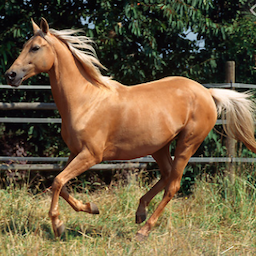

In [15]:
img

In [16]:
img.size

(256, 256)

In [17]:
label

0

In [18]:
dataset.class_names[label]

'Akhal-Teke'

In [19]:
print(f'Number of samples in the dataset: {len(dataset)}\n')

Number of samples in the dataset: 670



### Transforms

In [20]:
mean = [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [21]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [22]:
dataset=HorseDataset(path, transform=transform)

### Split the data into train val, and test set (starified)

In [23]:
def stratified_split_dataset(dataset, val_fraction=0.15, test_fraction=0.15, seed=42):

    labels = np.array(dataset.labels)
    indices = np.arange(len(dataset))

    sss1 = StratifiedShuffleSplit(
        n_splits=1,
        test_size=test_fraction,
        random_state=seed
    )

    train_val_idx, test_idx = next(sss1.split(indices, labels))

    val_ratio_adjusted = val_fraction / (1 - test_fraction)

    sss2 = StratifiedShuffleSplit(
        n_splits=1,
        test_size=val_ratio_adjusted,
        random_state=seed
    )

    train_idx, val_idx = next(
        sss2.split(train_val_idx, labels[train_val_idx])
    )

    train_idx = train_val_idx[train_idx]
    val_idx = train_val_idx[val_idx]

    return (
        Subset(dataset, train_idx),
        Subset(dataset, val_idx),
        Subset(dataset, test_idx)
    )


In [24]:
train_dataset, val_dataset, test_dataset = stratified_split_dataset(dataset)

In [25]:
print(f"Length of training dataset:   {len(train_dataset)}")
print(f"Length of validation dataset: {len(val_dataset)}")
print(f"Length of test dataset:       {len(test_dataset)}")

Length of training dataset:   468
Length of validation dataset: 101
Length of test dataset:       101


In [26]:
#updating transforms
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform   = transform
test_dataset.dataset.transform  = transform

### Create Dataloader objects

##### Random sampling

In [27]:
subset_labels = [ train_dataset.dataset.labels[i] for i in train_dataset.indices]

class_counts = Counter(subset_labels)

num_samples = len(subset_labels)
class_weights = {cls: num_samples / count for cls, count in class_counts.items()}

sample_weights = [class_weights[label] for label in subset_labels]
sample_weights = torch.DoubleTensor(sample_weights)

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights), 
    replacement=True                 
)

In [28]:
batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=sampler)

val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

#### Display some images

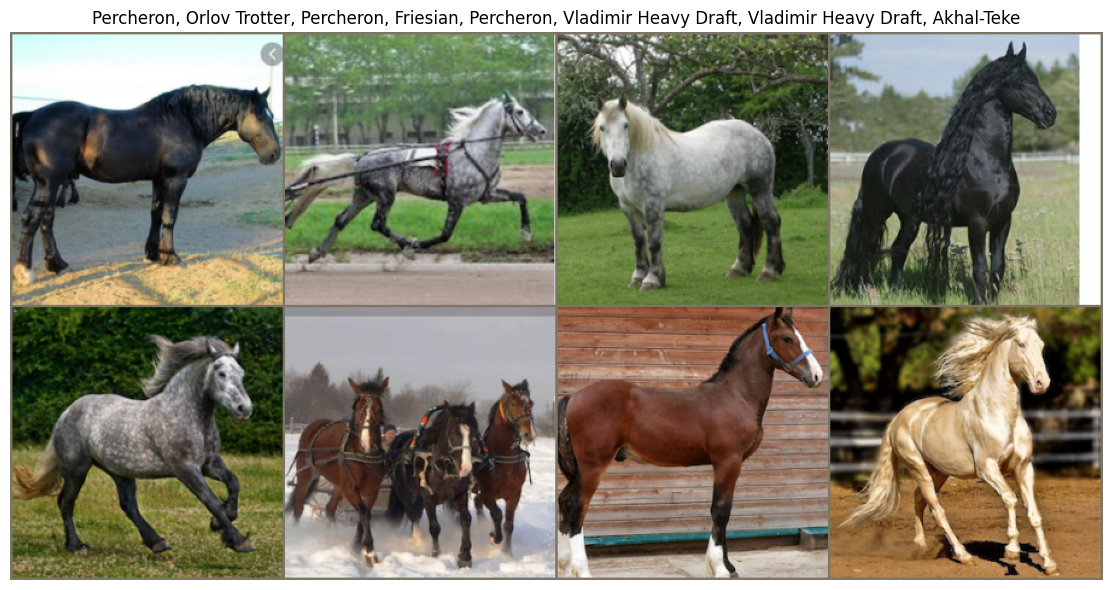

In [50]:
visualize_batch(train_dataloader, dataset.class_names, num_images=8)

### Define Model

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [33]:
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import vgg11, VGG11_Weights

##### model from scratch


In [ ]:
# class SimpleCNN(nn.Module):
#     def __init__(self, num_classes=7):
#         super(SimpleCNN, self).__init__()

#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
#         self.bn1   = nn.BatchNorm2d(16)

#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
#         self.bn2   = nn.BatchNorm2d(32)

#         self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.bn3   = nn.BatchNorm2d(64)

#         self.relu = nn.ReLU()
#         self.pool = nn.MaxPool2d(2, 2)

#         self.fc1 = nn.Linear(64 * 28 * 28, 256)
#         self.fc2 = nn.Linear(256, num_classes)

#         self.dropout = nn.Dropout(0.2)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.pool(x)

#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.relu(x)
#         x = self.pool(x)

#         x = self.conv3(x)
#         x = self.bn3(x)
#         x = self.relu(x)
#         x = self.pool(x)

#         x = x.view(x.size(0), -1)

#         x = self.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)

#         return x



# model_scratch = SimpleCNN(num_classes=7).to(device)


##### VGG11
transfer learning 

In [ ]:
vgg_ft = vgg11(weights=VGG11_Weights.DEFAULT)
 

In [45]:
for param in vgg_ft.parameters():
    param.requires_grad = False

num_ftrs = vgg_ft.classifier[6].in_features

vgg_ft.classifier[6] = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 7)
)


for param in vgg_ft.classifier[6].parameters():
    param.requires_grad = True


vgg_ft = vgg_ft.to(device)


##### resnet50
transfer learning 

In [35]:
resnet50_ft = resnet50(weights=ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 136MB/s] 


In [ ]:
for param in resnet50_ft.parameters():
    param.requires_grad = False

num_ftrs = resnet50_ft.fc.in_features

resnet50_ft.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.Dropout(0.2),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 7)  
)

for param in resnet50_ft.fc.parameters():
    param.requires_grad = True


resnet50_ft = resnet50_ft.to(device) 

### define Loss and Optimizer

In [43]:
loss_function = nn.CrossEntropyLoss()

In [37]:
vgg_optimizer_ft = optim.SGD(vgg_ft.classifier[6].parameters(), lr=0.001, momentum=0.9)

In [38]:
resnet_optimizer_ft = optim.SGD(resnet50_ft.fc.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)

### train the model
it should Save the best model and track train and val loss and accuracy


##### train function

In [35]:
def train_model(model, loss_function, optimizer, train_loader, val_loader, device, num_epochs=25):

    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 20)


        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        epoch_train_acc = correct_train / total_train

        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)


        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = loss_function(outputs, labels)

                running_val_loss += loss.item() * images.size(0)

                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_acc = correct_val / total_val

        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        print(
            f"Train Loss: {epoch_train_loss:.4f} | "
            f"Train Acc: {epoch_train_acc:.4f} | "
            f"Val Loss: {epoch_val_loss:.4f} | "
            f"Val Acc: {epoch_val_acc:.4f}"
        )

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best Val Acc: {best_val_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model, history


##### model from scratch 

In [52]:
# best_model_scratch, history_scratch = train_model(
#     model=model_scratch,
#     loss_function=loss_function,
#     optimizer=optimizer_scratch,
#     train_loader=train_dataloader,
#     val_loader=val_dataloader,
#     device=device,
#     num_epochs=25
# )

##### vgg

In [49]:
best_model_vgg, history_vgg = train_model(
    model=vgg_ft,
    loss_function=loss_function,
    optimizer=vgg_optimizer_ft,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    device=device,
    num_epochs=25
)


Epoch 1/25
--------------------
Train Loss: 1.7279 | Train Acc: 0.3632 | Val Loss: 1.4399 | Val Acc: 0.6337

Epoch 2/25
--------------------
Train Loss: 1.2807 | Train Acc: 0.5534 | Val Loss: 1.0420 | Val Acc: 0.7030

Epoch 3/25
--------------------
Train Loss: 0.9741 | Train Acc: 0.6902 | Val Loss: 0.8515 | Val Acc: 0.7921

Epoch 4/25
--------------------
Train Loss: 0.8675 | Train Acc: 0.7521 | Val Loss: 0.7597 | Val Acc: 0.8119

Epoch 5/25
--------------------
Train Loss: 0.7749 | Train Acc: 0.7799 | Val Loss: 0.7255 | Val Acc: 0.7921

Epoch 6/25
--------------------
Train Loss: 0.7198 | Train Acc: 0.7821 | Val Loss: 0.6824 | Val Acc: 0.8020

Epoch 7/25
--------------------
Train Loss: 0.6657 | Train Acc: 0.7906 | Val Loss: 0.6542 | Val Acc: 0.8218

Epoch 8/25
--------------------
Train Loss: 0.6510 | Train Acc: 0.7949 | Val Loss: 0.6203 | Val Acc: 0.8218

Epoch 9/25
--------------------
Train Loss: 0.6204 | Train Acc: 0.7906 | Val Loss: 0.5969 | Val Acc: 0.8119

Epoch 10/25
-------

##### resnet

In [44]:
best_model_resnet,history_resnet = train_model(
    model=resnet50_ft,
    loss_function=loss_function,
    optimizer=resnet_optimizer_ft,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    device=device,
    num_epochs=25
)


Epoch 1/25
--------------------
Train Loss: 1.8439 | Train Acc: 0.2735 | Val Loss: 1.8398 | Val Acc: 0.5050

Epoch 2/25
--------------------
Train Loss: 1.3215 | Train Acc: 0.6859 | Val Loss: 1.5060 | Val Acc: 0.6436

Epoch 3/25
--------------------
Train Loss: 0.9124 | Train Acc: 0.8547 | Val Loss: 1.1403 | Val Acc: 0.7327

Epoch 4/25
--------------------
Train Loss: 0.7575 | Train Acc: 0.8590 | Val Loss: 0.9413 | Val Acc: 0.7525

Epoch 5/25
--------------------
Train Loss: 0.5671 | Train Acc: 0.9209 | Val Loss: 0.8614 | Val Acc: 0.7525

Epoch 6/25
--------------------
Train Loss: 0.4793 | Train Acc: 0.9380 | Val Loss: 0.8193 | Val Acc: 0.7525

Epoch 7/25
--------------------
Train Loss: 0.4570 | Train Acc: 0.9359 | Val Loss: 0.7627 | Val Acc: 0.7624

Epoch 8/25
--------------------
Train Loss: 0.3888 | Train Acc: 0.9487 | Val Loss: 0.7499 | Val Acc: 0.7723

Epoch 9/25
--------------------
Train Loss: 0.3422 | Train Acc: 0.9423 | Val Loss: 0.7154 | Val Acc: 0.7624

Epoch 10/25
-------

### test the model on test set

##### test function

In [39]:
def evaluate_model(model, test_loader, loss_function, device):
    model.eval()  
    running_test_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_function(outputs, labels)
            running_test_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    test_loss = running_test_loss / len(test_loader.dataset)

    test_acc = accuracy_score(all_labels, all_preds)
    test_f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f} | Test F1: {test_f1:.4f}')
    
    return test_loss, test_acc, test_f1, all_preds, all_labels


##### vgg

In [ ]:
test_loss_vgg, test_acc_vgg, test_f1_vgg, all_preds_vgg, all_labels_vgg = evaluate_model(
    model=best_model_vgg,
    test_loader=test_dataloader,
    loss_function=loss_function,
    device=device
)

Test Loss: 0.3761 | Test Accuracy: 0.8614 | Test F1: 0.8440


##### resnet

In [ ]:
test_loss_resnet, test_acc_resnet, test_f1_resnet, all_preds_resnet, all_labels_resnet = evaluate_model(
    model=best_model_resnet,
    test_loader=test_dataloader,
    loss_function=loss_function,
    device=device
)

Test Loss: 0.3675 | Test Accuracy: 0.9010 | Test F1: 0.8804


##### model from scratch

In [53]:
# test_loss_scratch, test_acc_scratch, test_f1_scratch, all_preds_scratch, all_labels_scratch = evaluate_model(
#     model=best_model_scratch,
#     test_loader=test_dataloader,
#     loss_function=loss_function,
#     device=device
# )

### show some predictions with the images

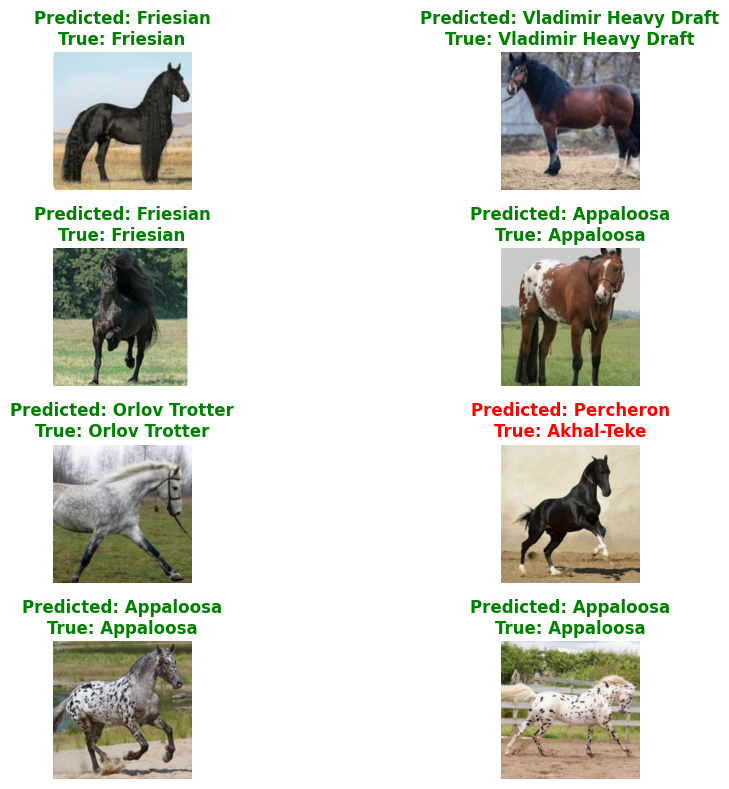

In [ ]:
visualize_predictions(
    model=best_model_vgg,
    dataloader=test_dataloader,
    class_names=dataset.class_names,
    device=device,
    num_images=8
)

### Analyze the results
Is the model overfitting/underfitting?
Plot the training and validation loss/accuracy curves

vgg11 training and validation losses values are both low and close which means the model is not overfitting, and the accuracies are similar meaning the model is generalizing well and learning meaningful features

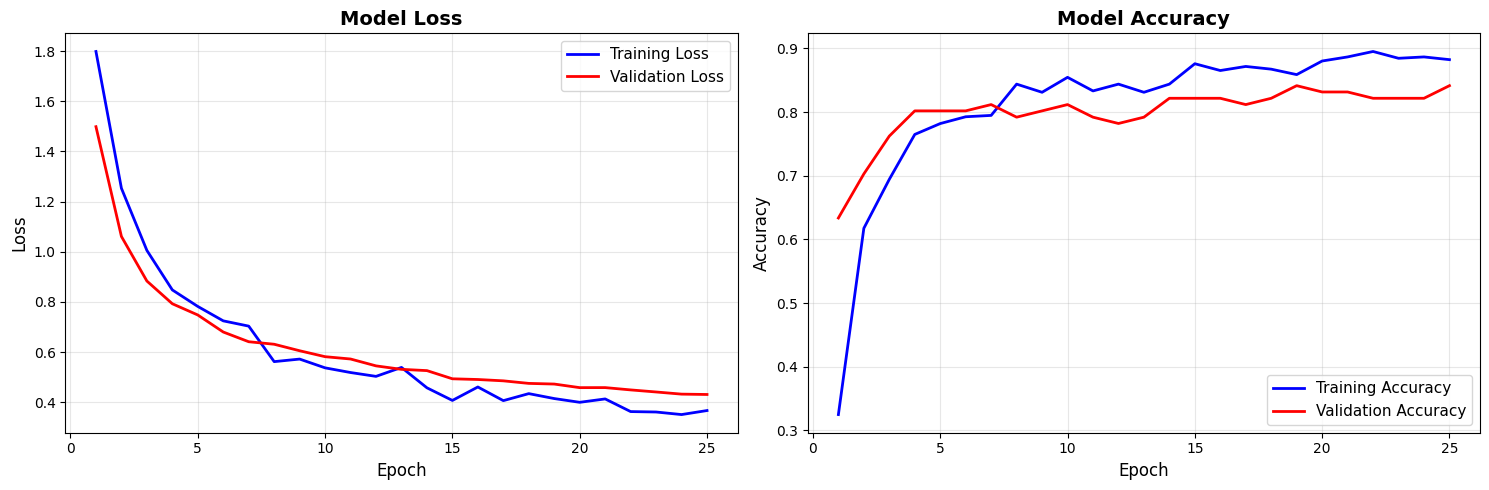

In [65]:
visualize_training_history(history_vgg)

resnet50 curves show signs of overfitting, the reason could be that resnet 50 is too complex for the problem, since it is  composed of 50 layers

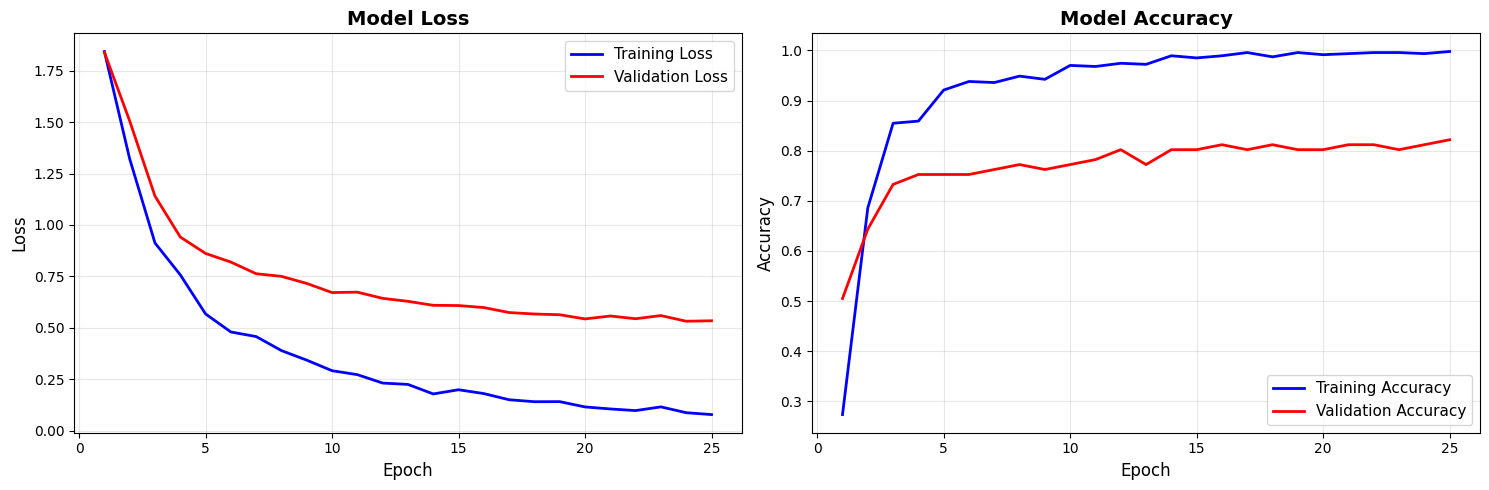

In [66]:
visualize_training_history(history_resnet)

the cnn model from scratch resulted in low accuracies, beacause it is too simple for the task 

In [54]:
# visualize_training_history(history_scratch)

### Load the model

##### loading vgg

In [51]:
torch.save(
    best_model_vgg.to('cpu').state_dict(),
    "best_vgg_horses.pth"
)


In [ ]:
vgg = vgg11(weights=VGG11_Weights.DEFAULT)
num_ftrs = vgg.classifier[6].in_features

vgg.classifier[6] = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 7)
)

vgg.load_state_dict(
    torch.load("best_vgg_horses.pth", map_location="cpu")
)


vgg = vgg.to(device)
vgg.eval()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [50]:
test_loss, test_acc, test_f1, all_preds, all_labels = evaluate_model(
    model=vgg,
    test_loader=test_dataloader,
    loss_function=loss_function,
    device=device
)

Test Loss: 0.4496 | Test Accuracy: 0.9109 | Test F1: 0.8988


### make prediction

In [ ]:
url = "https://www.horseproperties.net/blog/wp-content/uploads/2019/05/appaloosa-horse-768x483.jpg"


response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("RGB")

img_path = "temp_horse.jpg"
img.save(img_path)


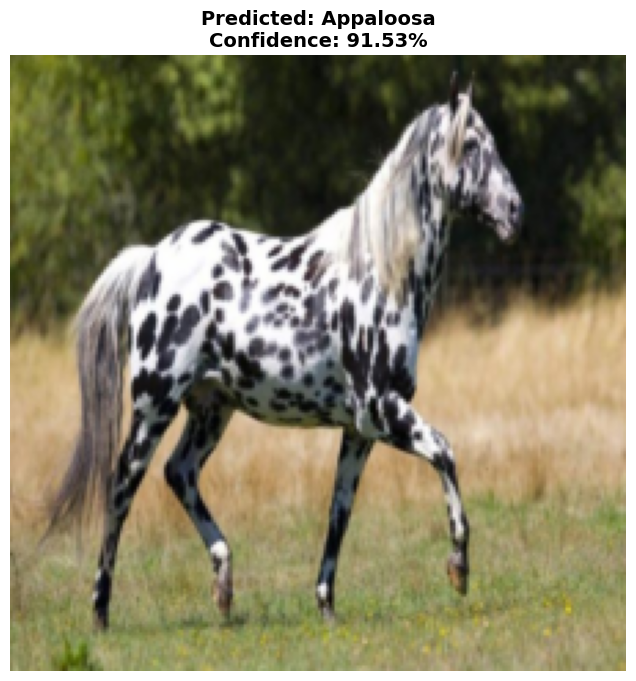

In [53]:
# Make prediction on a custom image
img_path = 'temp_horse.jpg'

visualize_single_prediction(
    vgg, 
    img_path,
    transform,
    dataset.class_names,
    device
)
plt.show()